Sample features:
     HCC     WCC   LCC    Tamb     Uin    Q
0  0.001  0.0005  0.03  253.15  1272.0  1.0
1  0.001  0.0005  0.03  273.15  1272.0  1.0
2  0.001  0.0005  0.03  293.15  1272.0  1.0
3  0.001  0.0005  0.03  313.15  1272.0  1.0
4  0.001  0.0005  0.03  253.15  3132.0  1.0
Sample targets:
0    86.117
1    89.914
2    93.532
3    96.944
4    92.271
Name: Delp, dtype: float64
Epoch [10/1000], Loss: 31859.2754
Epoch [20/1000], Loss: 30998.1543
Epoch [30/1000], Loss: 8506.4287
Epoch [40/1000], Loss: 10233.2070
Epoch [50/1000], Loss: 4212.6699
Epoch [60/1000], Loss: 3046.1562
Epoch [70/1000], Loss: 1191.8969
Epoch [80/1000], Loss: 1385.9059
Epoch [90/1000], Loss: 995.9943
Epoch [100/1000], Loss: 217.4557
Epoch [110/1000], Loss: 403.1090
Epoch [120/1000], Loss: 366.2851
Epoch [130/1000], Loss: 317.0057
Epoch [140/1000], Loss: 302.3369
Epoch [150/1000], Loss: 143.0911
Epoch [160/1000], Loss: 121.0111
Epoch [170/1000], Loss: 115.1867
Epoch [180/1000], Loss: 200.8092
Epoch [190/1000], Lo

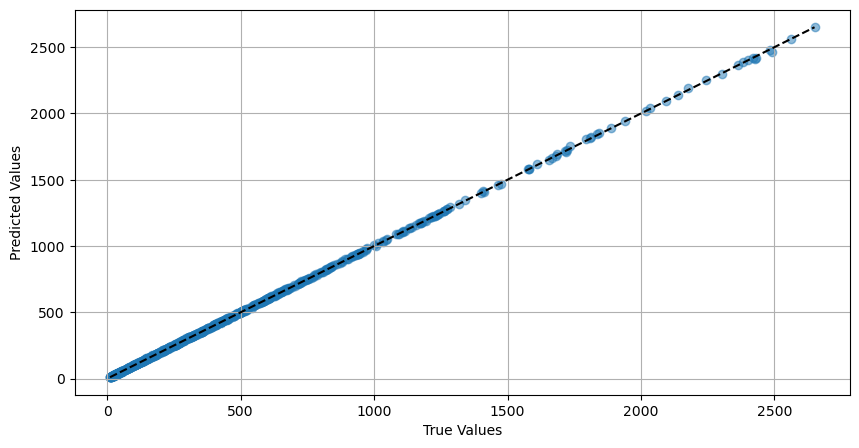

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        # Define the layers of the neural network.
        self.fc1 = nn.Linear(6, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, 1)    # Output layer for regression (one output)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Define the forward pass through the network.
        x = self.relu(self.fc1(x))  # Pass input through first layer and apply ReLU
        x = self.relu(self.fc2(x))  # Further processing by second layer and ReLU
        x = self.fc3(x)  # Final output without activation (linear output for regression)
        return x
    
def load_and_prepare_data(filepath):
    # Load data from a file and prepare it for training.
    try:
        # Read the file using whitespace as delimiter and skipping commented lines.
        # Check first few rows to see if they are reading correctly
        data = pd.read_csv(filepath, delim_whitespace=True, comment='%', header=None)
        
        # Since the file contains a commented header line, manually set the column names:
        data.columns = ['HCC', 'WCC', 'LCC', 'Tamb', 'Q', 'Uin',
                        'Temperature1', 'Temperature2', 'Temperature3', 'Temperature4',
                        'Temperature5', 'Temperature6', 'Pressure1', 'Pressure2', 'Delp',
                        'Velocity1', 'Velocity2', 'StackTemp1', 'StackTemp2']

    except Exception as e:
        # Print error and return None if loading fails
        print(f"Error reading the data file: {e}")
        return None, None

    # Extract features and target from the dataset based on the specified column labels
    feature_labels = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q']
    features = data.loc[:, feature_labels]  # Select columns for features by labels
    targets = data['Delp']  # Target output variable

    # Print a sample of the data points to verify correctness
    print("Sample features:")
    print(features.head())  # Print the first few rows of features
    print("Sample targets:")
    print(targets.head())  # Print the first few rows of targets

    return features, targets

def preprocess_data(features, targets):
    # Scale features and convert data to tensors.
    scaler = StandardScaler()
    try:
        # Scale the feature values
        features_scaled = scaler.fit_transform(features)
    except Exception as e:
        # Print error and return None if scaling fails
        print(f"Error scaling features: {e}")
        return None, None
    # Convert scaled features and targets to PyTorch tensors
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    targets_tensor = torch.tensor(targets.values, dtype=torch.float32).view(-1, 1)
    return features_tensor, targets_tensor

def prepare_loaders(features_tensor, targets_tensor, batch_size=64, test_size=0.2, random_state=42):
    # Prepare DataLoader objects for training and testing.
    # Split data into training and test sets
    features_train, features_test, targets_train, targets_test = train_test_split(
        features_tensor, targets_tensor, test_size=test_size, random_state=random_state)
    # Create Tensor datasets for training and testing
    train_dataset = TensorDataset(features_train, targets_train)
    test_dataset = TensorDataset(features_test, targets_test)
    # Create DataLoaders for training and testing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_model(model, train_loader, criterion, optimizer, num_epochs=1000):
    # Train the neural network model.
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients from previous iteration
            outputs = model(inputs)  # Compute model output
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
        # Log training progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, test_loader, criterion):
    # Evaluate the trained model using test data.
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_rmse = 0
    predictions, actuals = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Compute model output
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item() * inputs.size(0)  # Sum up batch loss
            
            # Calculate RMSE for each batch and accumulate
            rmse = torch.sqrt(loss)
            total_rmse += rmse.item() * inputs.size(0)
            
            # Store predictions and actual values for plotting
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())

    # Calculate average MSE, RMSE, and Relative Error
    mean_loss = total_loss / len(test_loader.dataset)
    mean_rmse = total_rmse / len(test_loader.dataset)
    relative_error = mean_rmse / np.mean(actuals)  # Relative error calculation

    print(f'Test MSE: {mean_loss:.4f}')
    print(f'Test RMSE: {mean_rmse:.4f}')
    print(f'Relative Error: {relative_error:.4f}%')

    # Plot true values vs predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

def main():
    # Main function to run the training and evaluation process.
    filepath = '/Users/hanheelee/Desktop/Projects/00_ML_Fuel_Cell/Set 1.txt'  # Path to data file
    features, targets = load_and_prepare_data(filepath)
    if features is None or targets is None:
        print("Failed to load data.")
        return
    features_tensor, targets_tensor = preprocess_data(features, targets)
    if features_tensor is None or targets_tensor is None:
        print("Failed to preprocess data.")
        return
    train_loader, test_loader = prepare_loaders(features_tensor, targets_tensor)
    model = RegressionNN()  # Instantiate the model
    criterion = nn.MSELoss()  # Loss function for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Optimizer
    train_model(model, train_loader, criterion, optimizer)  # Train the model
    evaluate_model(model, test_loader, criterion)  # Evaluate the model
    # Save the model's state dictionary
    torch.save(model.state_dict(), 'model.pth')
    # Load the model's state dictionary
    loaded_model = RegressionNN()
    loaded_model.load_state_dict(torch.load('model.pth'))
    loaded_model.eval()

if __name__ == "__main__":
    main()  # Execute the main function if the script is run directly.